# Mise en place du réseau de neurones

In [52]:
from music21 import converter, instrument, note, chord, stream
import numpy
from matplotlib import pyplot as plt
import keras
from sklearn.preprocessing import OneHotEncoder
from keras import Sequential, Model, regularizers
from keras.layers import LSTM, Dropout, Dense, Activation, Input, concatenate
import pandas as pd
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Attention, Bidirectional
import os
from music21.duration import Duration
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Embedding
from keras.utils import plot_model
import tensorflow as tf
from tqdm import tqdm
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error as smape_loss
import numpy as np
from keras.callbacks import ModelCheckpoint


In [ ]:
!unzip dataset.zip

unzip:  cannot find or open dataset.zip, dataset.zip.zip or dataset.zip.ZIP.


## Useful Functions

In [2]:
def get_notes(midi):
  notes = []

  notes_from_midi = midi.flatten().notesAndRests
  notes_sorted = sorted(notes_from_midi, key=lambda note: note.offset)

  prev_start = notes_sorted[0].offset

  for element in notes_sorted:
    if isinstance(element , note.Note):
      notes.append((float(element.offset), float(element.volume.velocity),float(element.seconds), str(element.pitch), float(element.offset-prev_start)))
    elif isinstance(element, chord.Chord):
      #notes.append((float(element.offset), float(element.volume.velocity), float(element.seconds), '+'.join(str(n) for n in element.normalOrder)))
      for noteChord in element.pitches:
        notes.append((float(element.offset),float(element.volume.velocity), float(element.seconds), str(noteChord), float(element.offset-prev_start)))

    elif isinstance(element, note.Rest):
        # Bizarre car main gauche et droite flatten (réunie)
        # Voir autre implémentation
        notes.append((float(element.offset), 0,float(element.seconds), "REST", float(element.offset-prev_start)))

    prev_start = element.offset
  return notes

def check_pitch(x):
  if ('+' in x) or x.isdigit():
        notes_in_chord = x.split('+')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord =chord.Chord(notes).pitches[0].midi
        return new_chord
    # pattern is a note
  elif 'REST' in x:
    return 0
  else:
        new_note = note.Note(x).pitch.midi
        return new_note


In [3]:
def prepare_sequence(data, sequence_length, network_input, network_output):
  # create input sequences and the corresponding outputs
  for i in range(0, len(data) - sequence_length, 1):
      sequence_in = data[i:i + sequence_length]
      sequence_out = data[i + sequence_length]
      network_input.append(sequence_in)
      network_output.append(sequence_out)
  return (network_input, network_output)

def reshape_array_input(array_tensor, sequence_length):
  n_patterns = len(array_tensor)
  array_reshaped = numpy.reshape(array_tensor, (n_patterns, sequence_length, -1))
  return array_reshaped

def reshape_array_output(array_tensor, sequence_length):
  n_patterns = len(array_tensor)
  array_reshaped = numpy.reshape(array_tensor, (len(array_tensor), -1))
  return array_reshaped

## Extracting songs informations

In [4]:
note_all_songs = []
for folder in tqdm(os.walk("dataset")):
    if len(folder) != 3:
      continue
    else:
      for file in folder[2]:
        file_path = str(folder[0])+"/"+file

        # convertit la piste midi
        midi = converter.parse(file_path)

        # récupère les notes, volume, dureées...
        notes = get_notes(midi)

        # ajoute à une liste globale
        note_all_songs.append(notes)

3it [00:58, 19.60s/it]


In [8]:
# fais un dataframe à partir de toutes les notes (sans distinctions)
df = pd.DataFrame([], columns=['offset','volume','duration', 'note_str', 'step'])
df = df.reset_index(drop=True)
for elem in note_all_songs:
    df2 = pd.DataFrame(elem, columns=['offset','volume','duration', 'note_str', 'step'])
    df2 = df2.reset_index(drop=True)
    df =pd.concat([df,df2])
    df = df.reset_index(drop=True)
df['note_int'] = df['note_str'].apply(check_pitch)

In [10]:
df.head()

,offset,volume,duration,note_str,step,note_int
0,0.0,49.0,0.115794,E-4,0.0,63
1,0.0,49.0,0.115794,B3,0.0,59
2,0.0,49.0,0.115794,E4,0.0,64
3,0.0,48.0,0.115794,G#3,0.0,56
4,0.0,48.0,0.115794,E-3,0.0,51


## Préparation des données

Si dans la partie de la mise en place des modèles statistiques et naïfs on avait pas forcément beaucoup traité les données mis à part transformer les notes en entier ici cela est autre.
En effet, les réseaux de neurones permettent une plus grande liberté quant à la manière d'intégrer les données, en plus de ses capacités bien plus complètes.
Dans un premier temps, on va transformer nos notes (str) en classes one-hot encodées pour les classifier par la suite ; on peut faire de même pour le volume et la durée en leur attribuant des intervalles que l'on convertit ensuite en classe one-hot encodées. Dans cette partie pour que l'encodage soit effectif il est nécessaire d'avoir toutes les données, c'est pourquoi elles sont toutes rassemblées dans un dataframe, c'est pour que l'encodage one-hot des notes se fassent sur toutes les notes possibles (il en va de soit pour la durée des notes et leur volume).


A ce niveau, on ne fait qu'netraîner les modèles d'encodage, la transformation se fera plus tard lors de la création de séquence pour l'entraînement et la prédiction.

### Création de l'encodage

In [12]:
oh_notes =  OneHotEncoder().fit(df[['note_str']])

In [13]:
dict_volume_class = {
    "very low":10,
    "low":30,
    "low medium":50,
    "medium":70,
    "high": 90,
    "very high":128
}
bins_volume = list(dict_volume_class.values())
bins_volume.insert(0,-0.1)
values_volume = list(dict_volume_class.keys())
df["volume_class"] = pd.cut(df["volume"], bins=bins_volume, labels=values_volume)
oh_volume =  OneHotEncoder().fit(df[['volume_class']])

In [15]:
dict_duration_class = {
"very short" : 0.1,
"short" :0.25,
"medium":0.5,
"medium-long":0.75,
"long":1.0,
"very long": 1.5,
"kilometer long":2.0,
"yearlight distance":3.0,
"super mega long":df['duration'].max() if df['duration'].max()>3.0 else 4.0
}
bins_duration = list(dict_duration_class.values())
bins_duration.insert(0,-0.1)
values_duration = list(dict_duration_class.keys())
df["duration_class"] = pd.cut(df["duration"], bins=bins_duration, labels=values_duration)

oh_duration =  OneHotEncoder().fit(df[['duration_class']])

#### Etudes des classes encodées

##### Volume

L'encodage du volume n'est pas forcément utile, car comme le montre le graphique les classes ne sont pas équilibrés du tout, il y a énormément de note au volume moyens et très peu avec des volumes élevés.
L'information n'ayant pas un impact fondamental dans ce que l'on souhaite prédire, cela n'a que peu d'importance, par contre si l'on souhaite prédire le volume de manière sérieuse, il faudra song à un autre moyen. Le déséquilibre de ces classes va forcément biaiser les prédictions.

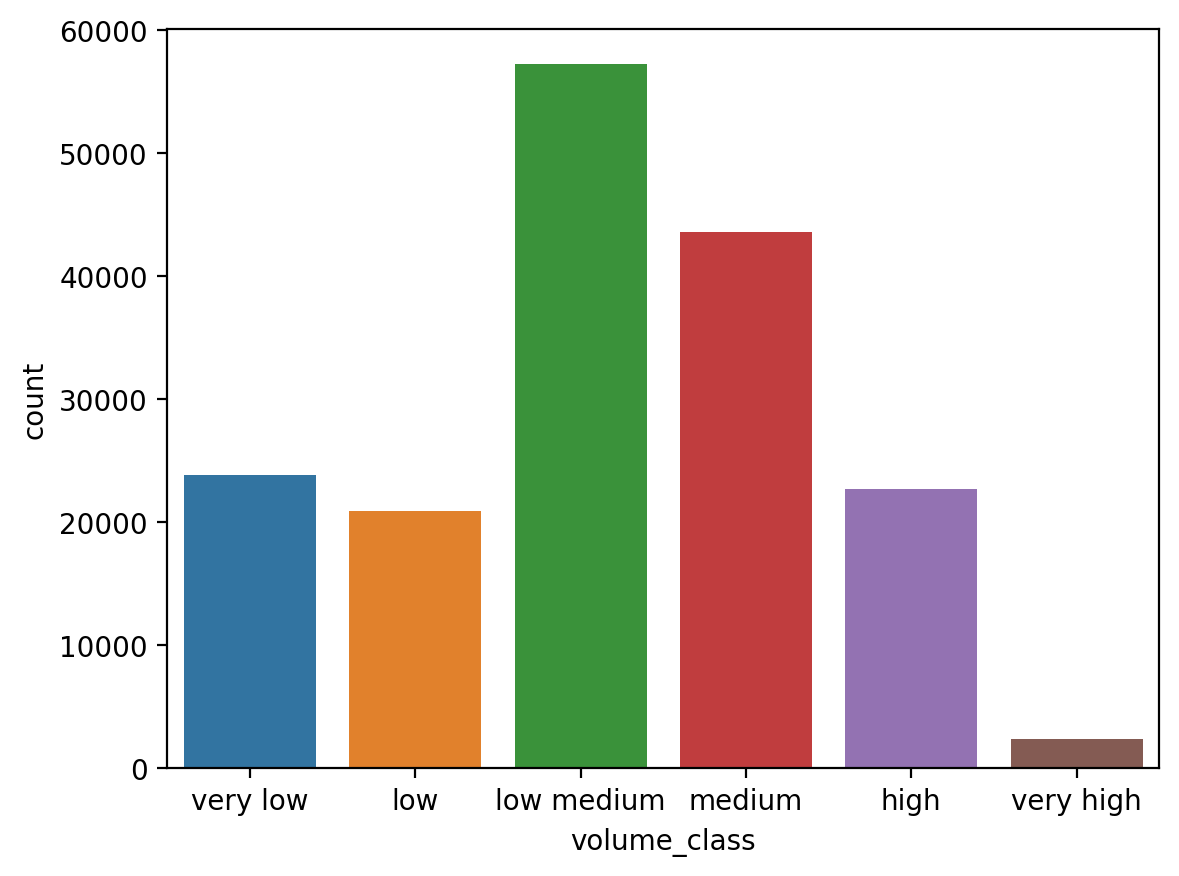

In [19]:
sns.countplot(data=df, x="volume_class");

##### Durée

L'observation pour les volumes s'appliquent aussi pour la durée des notes, les classes sont encore plus déséquilibrées. Comme ici la durée est une donnée importante, on ne va pas garder son encodage sous forme de classe, mais la garder sous sa forme entière afin de faciliter les choses.

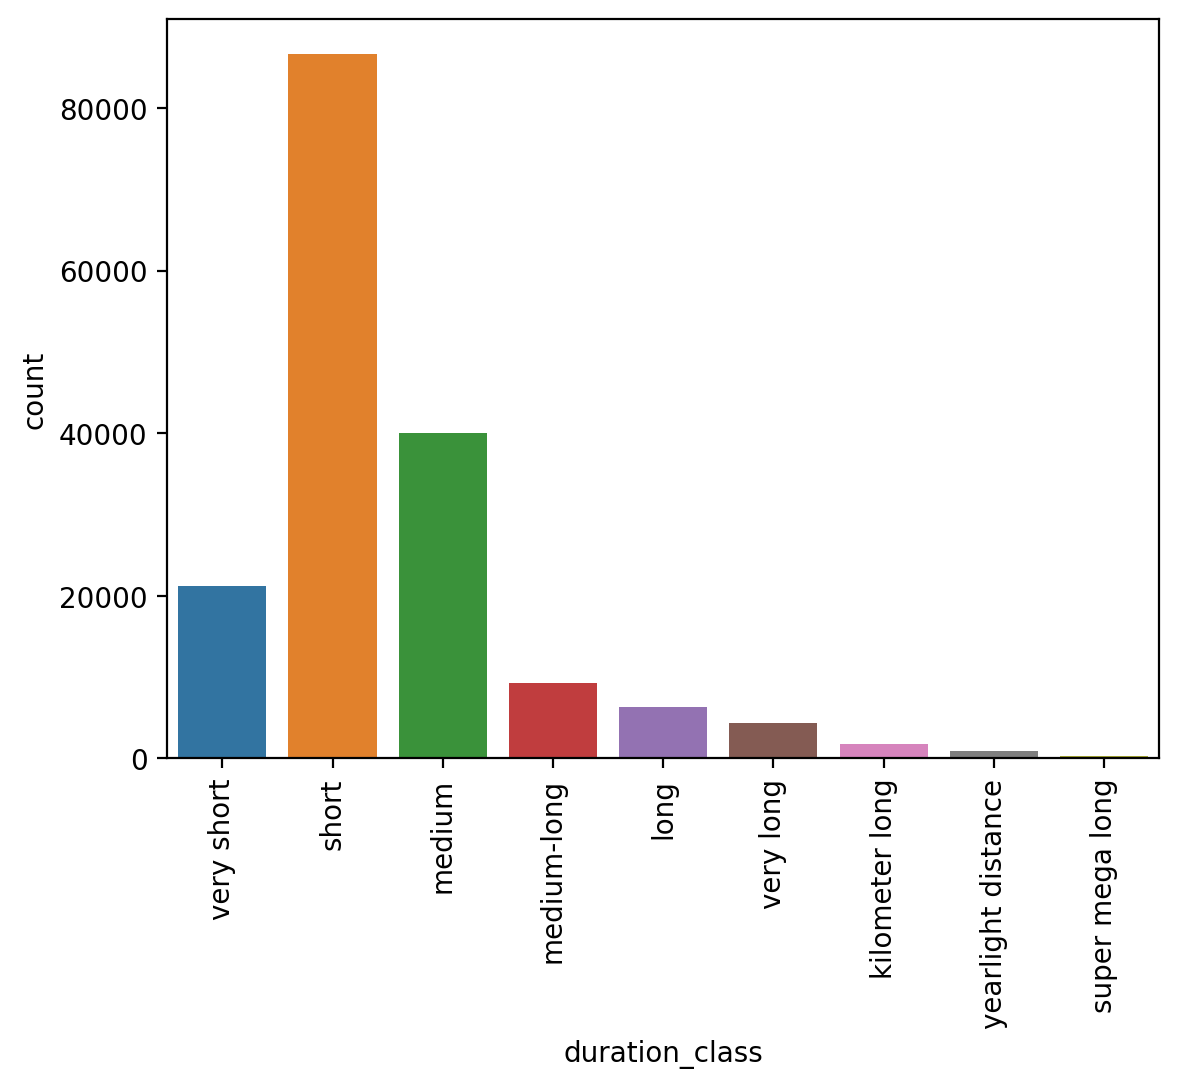

In [21]:
sns.countplot(data=df, x="duration_class");
plt.xticks(rotation=90);

##### Notes

L'encodage des notes en one-hot est un choix. Un autre choix aurait pu être de prendre leur forme entière et de faire de la régression dessus.
Ce choix se fait avec les expérimentations que l'on a fait, le modèle semble mieux prédire lorsque les notes sont encodées sous forme de classes plutôt que d'entier.

In [22]:
oh_notes.categories_

[array(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'B-1', 'B-2', 'B-3', 'B-4',
        'B-5', 'B-6', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'C#1', 'C#2',
        'C#3', 'C#4', 'C#5', 'C#6', 'C#7', 'C1', 'C2', 'C3', 'C4', 'C5',
        'C6', 'C7', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'E-1', 'E-2',
        'E-3', 'E-4', 'E-5', 'E-6', 'E-7', 'E1', 'E2', 'E3', 'E4', 'E5',
        'E6', 'E7', 'F#1', 'F#2', 'F#3', 'F#4', 'F#5', 'F#6', 'F1', 'F2',
        'F3', 'F4', 'F5', 'F6', 'F7', 'G#1', 'G#2', 'G#3', 'G#4', 'G#5',
        'G#6', 'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'REST'], dtype=object)]

In [25]:
len(oh_notes.categories_[0])

79

Il y a donc 79 notes différentes, ce qui veut dire que nos données en entrée contiendront des array de 79 0 dont un 1 pour l'encodage one-hot.

### Mise en place sous forme de séquences

Maintenant que les données sont prêtes à être traitées, il faut créer nos séquences de notes.
En effet, il faut garder à l'esprit que les notes de pianos sont une série temporelle et qu'on ne peut pas directement les fournir en l'état au modèle au peine de perdre cette corrélation dans l'ordre des notes.
A la manière d'une série temporelle classique, nous allons créer des séquences d'une certaine longueur ce qui formera une entrée, et on prendra la note suivant cette séquence ce qui formera une sortie. En faisant ca pour chaque morceaux de musique, on constituera petit à petit notre jeu de données.

Pour des raisons de temps de calcul et de complexité, nous choisissons des séquences d'une longeur de 25.
Autrement dit, pour chaque morceau de musique on prend un enchaînement de 25 notes et celle d'après représente la sortie à prédire.

In [26]:
sequence_length = 25

Pour garder une cohérence dans les données, pour chaque morceau indépendamment des autres : 
- On récupère ses informations
- Encodons ses notes, la durée des notes et leur volume
- Créons des séquences de longueur donnée en récupérant la note suivante et les ajoutent à des array

In [27]:
input_note, output_note = [], []
input_offset, output_offset = [], []
input_volume, output_volume = [], []
input_duration, output_duration = [], []
input_step, output_step = [], []
input_simul, output_simult = [],[]

In [28]:
# pour chaque music, on la transforme en dataframe, transforme les notes, durées et volumes
for music in note_all_songs:
  df_music = pd.DataFrame(music, columns=['offset','volume','duration', 'note_str', 'step'])

  # encode le volume et la durée
  df_music["volume_class"] = pd.cut(df_music["volume"], bins=bins_volume, labels=values_volume)
  df_music["duration_class"] = pd.cut(df_music["duration"], bins=bins_duration, labels=values_duration)


  # transform en one hot à partir des modèles entrainés
  notes_encoded = oh_notes.transform(df_music[['note_str']]).toarray()
  volume_encoded = oh_volume.transform(df_music[['volume_class']]).toarray()
  duration_encoded = oh_duration.transform(df_music[['duration_class']]).toarray()

  # prépare les input (longeur = sequence_length) pour chaque morceau
  input_offset, output_offset = prepare_sequence(df_music['offset'].values, sequence_length, input_offset, output_offset)
  input_note, output_note = prepare_sequence(notes_encoded, sequence_length, input_note, output_note)
  input_volume, output_volume = prepare_sequence(volume_encoded, sequence_length, input_volume, output_volume)
  input_duration, output_duration = prepare_sequence(df_music["duration"].values, sequence_length, input_duration, output_duration)
  input_step, output_step = prepare_sequence(df_music['step'].values, sequence_length, input_step, output_step)

In [31]:
input_note[0:2]

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])]

Maintenant que l'on a toutes nos séquences ainsi que la note suivante, il est nécessaire de remettre en forme (reshape) ces array contenant les données d'entraînement.

Par exemple, les données d'entrée pour les notes est une array contenant des sous array (séquences de notes), qui elle-même contient 25 array de note one-hot encodées. En l'état c'est inutilisable pour un réseau de neurones, il est nécessaire de reshape ces données sous la forme :  (nombre de séquences, longeur des séquences, longueur d'un one-hot). Ainsi on aura : 
- Note : (nombre de séquences totales, 25, 79) (séquences de 25 notes, notes one-hot encodées sur 79 classes)
- Step, Durée : (nombre de séquences totales, 25, 1) (séquence de 25 step/durée, en entier donc 1)
- Volume : (nombre de séquences totales, 25, 6) (séquences de 25 volume, volume one-hot encodés sur 6 classes)

Et il en va de même pour les sorties à qui on remplace le 25 par un 1, car on possède une note avec ses 25 précédentes.

In [32]:
# on reshape tout
input_note_reshaped= reshape_array_input(input_note, sequence_length)
output_note_reshaped = reshape_array_output(output_note, sequence_length)

input_offset_reshaped = reshape_array_input(input_offset, sequence_length)
output_offset_reshaped = reshape_array_output(output_offset, sequence_length)

input_volume_reshaped= reshape_array_input(input_volume, sequence_length)
output_volume_reshaped = reshape_array_output(output_volume, sequence_length)

input_duration_reshaped= reshape_array_input(input_duration, sequence_length)
output_duration_reshaped = reshape_array_output(output_duration, sequence_length)

input_step_reshaped= reshape_array_input(input_step, sequence_length)
output_step_reshaped = reshape_array_output(output_step, sequence_length)

In [34]:
print("Shape input note : ",input_note_reshaped.shape)
print("Shape input duration : ",input_duration_reshaped.shape)
print("Shape input step : ",input_step_reshaped.shape)
print("Shape input volume : ",input_volume_reshaped.shape)

Shape input note :  (169392, 25, 79)
Shape input duration :  (169392, 25, 1)
Shape input step :  (169392, 25, 1)
Shape input volume :  (169392, 25, 6)


## Création du modèle

Maintenant que les données sont enfin prêtes on peut créer le modèle. Ce qui n'a pas été dit c'est que pour mettre les données sous la forme que l'on veut il faut avoir une idée du modèle que l'on va faire et de sa structure.
Comme on peut le voir nos données sont toutes séparées, nous avons fait en sorte d'avoir un jeu de données pour les notes, un pour la durée...

Pour la prédiction 2 choix pouvait se faire sur les données en entrée :
- Soit, on souhaite prédire la note sous sa forme complète en se disant qu'une note est consitutuée de son pitch, d'une durée, d'un volume et d'un step (un block) et qu'on va donc fournir en entrée ce bloc indivisible de donnée (les 4 d'un coup). Cette approche à l'avantage d'être moins complexe et plus rapide, mais on peut tout de suite manquer de nuances puisqu'il sera possible d'avoir certaine avec très peu de variation de durée par exemple.
- Soit, on part du principe que certes une notes dans sa forme complète peut avoir de l'influence, et qu'en dehors de ça, le pitch à lui-même une influence, autant que la durée, le volume et le step chaucn indépendamment. Autremment, le pitch a un caractère temporel, autant que la volume, la durée et le step. Ce n'est plus uniquement la note dans sa globalité, mais la note et ses composantes qui ont un caractère temporel. Pour

Nous sommes donc partis sur la deuxième approche ce qui justifie donc l'utilisation de 4 entrées séparées, une pour chaque composante de la note, d'où la consitution de données d'entrées séparées.

Il en va de même pour la sortie (la prédiction) :
- Soit on veut prédire la note dans sa globalité, ce qui a l'avantage d'être plus rapide moins complexe
- Soit on prédit indépendamment les composantes de la notes pour avoir plus de nuances.

Nous sommes donc parti encore une fois sur la deuxième option, ce qui jsutifiera l'utilisation de 4 sorties, une pour chaque composante de la note, ce qui explique aussi la consitution de jeu de sorties différents.

**Le modèle**
A partir des réfléxions antérieures, notre modèle aura donc 4 entrées et 4 sorties. Comme chaque entrée est considérée avoir son propre caractère temporelle, ce sera un LSTM à chaque entrée. Ensuite, on concatène les 4 entrées puisque même si chaque composante d'une note a un caractère temporelle, c'est aussi l'ensemble qui compte, l'association de toutes ces composantes qui forment une note, d'où la concaténation. Cet unique chemin est lui aussi soumis à des LSTM, pour enfin avoir 4 sorties distinctes.

- Pour les notes : la sortie n'aura pas d'activation, on va souhaite utiliser les logits de la couche pour appliquer de la température. La loss sera une categorical crossentropy prenant des logits
- Pour les step et les durées : la sortie aura une activation linéaire car c'est une tâche de régression. La loss sera une mean squared error avec pression positive, en somme cela influence le modèle lorsque celui-ci prend des bonnes décisions.
- Pour le volume : la sortie sera un softmax, on ne va pas souhaiter appliquer de température. La loss est une categorical_crossentropy


In [35]:
inputNotes_layer = Input(shape=(input_note_reshaped.shape[1], input_note_reshaped.shape[2]))
inputNotes = (LSTM(
        256,
        input_shape=(input_note_reshaped.shape[1], input_note_reshaped.shape[2]),
        dropout=0.3,
        return_sequences=True
    ))(inputNotes_layer)

inputVolume_layer = Input(shape=(input_volume_reshaped.shape[1], input_volume_reshaped.shape[2]))
inputVolume = (LSTM(
        256,
        input_shape=(input_volume_reshaped.shape[1], input_volume_reshaped.shape[2]),
        dropout=0.3,
        return_sequences=True
    ))(inputVolume_layer)

inputDuration_layer = Input(shape=(input_duration_reshaped.shape[1], input_duration_reshaped.shape[2]))
inputDuration = BatchNormalization()(inputDuration_layer)
inputDuration =(LSTM(
        256,
        input_shape=(input_duration_reshaped.shape[1], input_duration_reshaped.shape[2]),
        dropout=0.3,
        return_sequences=True,
    ))(inputDuration_layer)

inputStep_layer = Input(shape=(input_step_reshaped.shape[1], input_step_reshaped.shape[2]))
inputStep = BatchNormalization()(inputStep_layer)
inputStep = (LSTM(
        256,
        dropout=0.3,
        input_shape=(input_step_reshaped.shape[1], input_step_reshaped.shape[2]),
        return_sequences=True
    ))(inputStep_layer)



attention_notes = Attention()([inputNotes, inputStep, inputDuration])

inputs = concatenate([inputNotes, inputVolume, inputDuration, inputStep, attention_notes])

x = LSTM(512, return_sequences=True, dropout=0.3)(inputs)
x = LSTM(512)(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512)(x)

outputNotes = Dense(256)(x)
outputNotes = Dropout(0.3)(outputNotes)
outputNotes = Dense(output_note_reshaped.shape[1], activation=None, name="Note")(outputNotes)

outputVolume = Dense(256)(x)
outputVolume = BatchNormalization()(outputVolume)
outputVolume = Dropout(0.3)(outputVolume)
outputVolume = Dense(output_volume_reshaped.shape[1], activation='softmax', name="Volume")(outputVolume)

outputDuration = Dense(512)(x)
outputDuration = BatchNormalization()(outputDuration)
outputDuration = Dropout(0.1)(outputDuration)
outputDuration = Dense(output_duration_reshaped.shape[1], activation="linear", name="Duration")(outputDuration)

outputOffset =  Dense(512)(x)
outputOffset = BatchNormalization()(outputOffset)
outputOffset = Dropout(0.1)(outputOffset)
outputOffset = Dense(output_step_reshaped.shape[1], activation="linear", name="Offset")(outputOffset)



model = Model(inputs=[inputNotes_layer,inputStep_layer,  inputVolume_layer, inputDuration_layer], outputs=[outputNotes, outputOffset, outputVolume, outputDuration])

In [36]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=100,)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Comme chaque sortie est indépendante, il est possible de jouer sur l'apprentissage du modèle en modifiant les poids de la perte des sorties. En augmentant le facteur de certains poids, on pourra dire au modèle de centrer l'apprentissage autour d'une composante. 
Après avoir essayé plusieurs fois, l'effet étant très important sur les prédictions nous avons préféré les laisser à un.

In [37]:
loss_weights = [1,1,1,1]

In [38]:
metrics = {
    "Note" : 'accuracy',
    "Volume" : 'accuracy',
    "Offset": "mean_absolute_error",
    "Duration": "mean_absolute_error"
}

In [39]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)


In [40]:
model.compile(metrics=metrics,loss=[tf.keras.losses.CategoricalCrossentropy(from_logits=True), mse_with_positive_pressure, "categorical_crossentropy", mse_with_positive_pressure], optimizer=optimizer, loss_weights=loss_weights)

In [41]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 79)]             0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 25, 1)]              0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 25, 1)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 25, 256)              344064    ['input_1[0][0]']             
                                                                                              

In [42]:
import os

cp_callback = keras.callbacks.ModelCheckpoint(
    'model_weights_epoch3.h5',  # Nom du fichier de sauvegarde avec un espace réservé pour le numéro de l'époque
    save_weights_only=True,  # Sauvegarder uniquement les poids, pas l'ensemble du modèle
    verbose=1  # Afficher un message lors de la sauvegarde
    )

checkpoint = ModelCheckpoint('weights1/weights.{epoch:02d}.h5',  # Nom du fichier de poids
                             save_weights_only=True,       # Ne sauvegarder que les poids
                             save_best_only=False,         # Sauvegarder à chaque époque
                             period=1)

## Entraînement du modèle

In [43]:
history = model.fit([input_note_reshaped, input_step_reshaped,  input_volume_reshaped, input_duration_reshaped], [output_note_reshaped, output_step_reshaped, output_volume_reshaped, output_duration_reshaped], epochs=400, batch_size=128, callbacks=[cp_callback])

Epoch 1/400
  15/5294 [..............................] - ETA: 1:09:58 - loss: 23.4977 - Note_loss: 4.8445 - Offset_loss: 8.4308 - Volume_loss: 1.9081 - Duration_loss: 8.3143 - Note_accuracy: 0.0250 - Offset_mean_absolute_error: 1.1925 - Volume_accuracy: 0.4083 - Duration_mean_absolute_error: 1.1504

KeyboardInterrupt: 

## Prédiction

### Ouverture du morceau à prédire

Le modèle est entraîné (logiquement), on peut passer à l'étape de prédiction.
Pour prédire, on commence par choisir un morceau que l'on veut un '.mid' auquel on va appliquer les mêmes transformations que pour les données en entrée (transformation one-hot)

In [46]:
midi = converter.parse("dataset/chopin/chp_op18.mid")
notes = get_notes(midi)

df_input_predict = pd.DataFrame(notes, columns=['offset','volume','duration', 'note_str', 'step'])

In [47]:
df_input_predict

,offset,volume,duration,note_str,step
0,0.00,80.0,0.576729,B-4,0.00
1,0.00,0.0,0.576729,REST,0.00
2,2.00,74.0,0.071077,B-4,2.00
3,2.00,0.0,0.284306,REST,0.00
4,2.25,0.0,0.071077,REST,0.25
...,...,...,...,...,...
6077,1073.75,0.0,0.212766,REST,0.25
6078,1073.75,0.0,0.212766,REST,0.00
6079,1074.00,113.0,1.607143,E-3,0.25
6080,1074.00,96.0,1.607143,E-1,0.00


### Création des données

Maintenant que le morceau est ouvert, par soucis de détails on va lui appliquer exactement les mêmes transformations qu'au début. De cette manière on aura des jeu d'entraînement basés sur le morceau que l'on veut prédire, ce qui facilitera la prédiction ultérieure.
Cela peut paraître laborieu pour si peu, mais au vue du temps que cela prend (très court), on se le permet.

On encode les données en utilisant les mêmes encodeurs qu'avant, et les mêmes intervalles lors de la création de classes.

In [48]:
input_note_input_predict, output_note_input_predict = [], []
input_offset_input_predict, output_offset_input_predict = [], []
input_volume_input_predict, output_volume_input_predict = [], []
input_duration_input_predict, output_duration_input_predict = [], []
input_step_input_predict, output_step_input_predict = [], []

In [49]:

# encode le volume et la durée
df_input_predict["volume_class"] = pd.cut(df_input_predict["volume"], bins=bins_volume, labels=values_volume)
df_input_predict["duration_class"] = pd.cut(df_input_predict["duration"], bins=bins_duration, labels=values_duration)


# transform en one hot à partir des modèles entrainés
notes_encoded = oh_notes.transform(df_input_predict[['note_str']]).toarray()
volume_encoded = oh_volume.transform(df_input_predict[['volume_class']]).toarray()
duration_encoded = oh_duration.transform(df_input_predict[['duration_class']]).toarray()

# prépare les input (longeur = sequence_length) pour chaque morceau
# garde certaine cohérence au morceau même
input_offset_input_predict, output_offset_input_predict = prepare_sequence(df_input_predict['offset'].values, sequence_length, input_offset_input_predict, output_offset_input_predict)
input_note_input_predict, output_note_input_predict = prepare_sequence(notes_encoded, sequence_length, input_note_input_predict, output_note_input_predict)
input_volume_input_predict, output_volume_input_predict = prepare_sequence(volume_encoded, sequence_length, input_volume_input_predict, output_volume_input_predict)
input_duration_input_predict, output_duration_input_predict = prepare_sequence(df_input_predict["duration"].values, sequence_length, input_duration_input_predict, output_duration_input_predict)
input_step_input_predict, output_step_input_predict = prepare_sequence(df_input_predict['step'].values, sequence_length, input_step_input_predict, output_step_input_predict)

### Prédiction de la suite ou d'un quelconque passage

#### Chargement des poids (s'ils existent)

In [ ]:
model.load_weights('/content/model_weights_epoch1.h5')

 #### Prédire les n prochaines notes

Les données du morceau à prédire sont maintenant prêtes, il faut maintenant prédire le morceau à partir d'où on veut. En gardant en tête que ce sont des séquences de 25, on peut commencer à prédire un morceau à partir de sa 26ème note ou à partir de la dernière.
Les données en entrée seront 4 tensor d'une longeur de 25 chacun contenant une composante d'une note, une fois donnée en entrée du modèle, le modèle donnera 4 sorties, une pour chaque composante avec un traitement qui lui sera propre.

In [50]:
predict_from = 100

In [51]:
pattern_note = input_note_input_predict[predict_from]
pattern_offset = input_offset_input_predict[predict_from]
pattern_volume = input_volume_input_predict[predict_from]
pattern_duration = input_duration_input_predict[predict_from]
pattern_step = input_step_input_predict[predict_from]

Maintenant que tout est bon, on peut prédire.
Bien sûr il reste nécessaire de reshape les données pour leur données le bon format (1, 25, ...).
Une fois cela fait, on peut prédire et récupérer les sorties prédites.

Comme mentionné dans la description du modèle, si pour la sortie de la durée et du step ce sont des entiers car régressions, il n'y a pas forcément de traitement précis à adopter car la sortie peut être directement exploitée. Le volume sort d'un softmax, ainsi en récupérant l'indice où la probabilité est la plus élevée on peut reconsituer une array one-hot correspondant et utiliser l'encodeur du volume pour avoir la classe correspondante et ainsi le volume associé.
Pour les notes c'est autre chose, il a été mentionné qu'on utiliserait les logits. En somme, la sortie des notes sera une array comme si c'était un softmax mais avant l'application du softmax. On aura donc des chiffres plus ou moins élevées n'étant PAS des probabilités. On les garde dans cet état pour appliquer de la température (moyen de faire varier les résultats), car le modèle peut très vite rencontrer une boucle et ne prédire que la même chose. Donc, on récupère les logits en sortie, les divisons par le température et appliquons le calcul d'un softmax pour obtenir les probabilités, et prenons la classe selon une loi multinomial respectant les probabilités calculées et indiquées.

Bien évidemment pour respecter la forme des données en entrée, à chaque prédiction, on prend les données prédites que l'on ajoute aux données utilisées pour prédire en gardant une taille de 25. De cette manière si au départ pour prédire les première notes on utilisent les données du vrai morceau, petit à petit on utilisera les anciennes prédicitions pour faire les nouvelles.

En possession de toutes ces prédictions de chacunes des composantes, on les ajoutent dans une array pour après les transformer en indicateur auditif. 

In [ ]:
# prediction time
prediction_output = []


prev_start = pattern_offset[-1]
for i in tqdm(range(200)):

    note_prediction_input = numpy.reshape(pattern_note, (1, len(pattern_note), -1))
    volume_prediction_input = numpy.reshape(pattern_volume, (1, len(pattern_volume), -1))
    duration_prediction_input = numpy.reshape(pattern_duration, (1, len(pattern_duration), -1))
    offset_prediction_input = numpy.reshape(pattern_offset, (1, len(pattern_offset), 1))
    step_prediction_input = numpy.reshape(pattern_step, (1, len(pattern_step), 1))

    prediction = model.predict([note_prediction_input, step_prediction_input, volume_prediction_input, duration_prediction_input], verbose=0)

    note_softmax = prediction[0]

    notes_pred = np.zeros(len(pattern_note[0]))
    notes_pred[np.argmax(prediction[0])] = 1

    a = note_softmax[0] / 1.0
    a = np.array(a, dtype=np.float64)
    max_logit = np.max(a)
    a = np.exp(a) / np.sum(np.exp(a))
    sample = np.random.multinomial(1, a)


    result_note = oh_notes.inverse_transform(sample.reshape(1, -1))
    pattern_note = numpy.concatenate([pattern_note, [sample]])
    pattern_note = pattern_note[1:]

    step_predict = prediction[1][0][0]
    pattern_step = numpy.concatenate([pattern_step, prediction[1][0]])
    prev_start += step_predict
    pattern_offset = numpy.concatenate([pattern_offset, [prev_start]])

    pattern_step = pattern_step[1:]
    pattern_offset = pattern_offset[1:]

    # la même avec le volume
    volume_pred = np.zeros(len(pattern_volume[1]))
    volume_pred[np.argmax(prediction[2])] = 1
    result_volume = oh_volume.inverse_transform(volume_pred.reshape(1, -1))
    pattern_volume = numpy.concatenate([pattern_volume, [volume_pred]])
    pattern_volume = pattern_volume[1:]

    duration_pred = prediction[3][0][0]
    duration_pred_rounded = round(duration_pred,3)
    pattern_duration = numpy.concatenate([pattern_duration, [duration_pred]])
    pattern_duration = pattern_duration[1:]

    volume_encoded = result_volume[0][0]
    volume_decoded = dict_volume_class[volume_encoded]
    
    prediction_output.append([result_note[0][0], step_predict, volume_decoded, duration_pred_rounded])


100%|██████████| 200/200 [00:15<00:00, 12.69it/s]


#### Etudes des résultats

In [ ]:
df_predicted = pd.DataFrame(prediction_output, columns=['note_str','step','volume', 'duration'])

In [ ]:
df_input_predict['note_int'] = df_input_predict['note_str'].apply(check_pitch)
df_predicted['note_int'] = df_predicted['note_str'].apply(check_pitch)

In [ ]:
true_output = df_input_predict[predict_from+25:predict_from+25+200]
predicted_output = df_predicted

##### Note prédites

In [ ]:
true_output_note = true_output.note_int.array
predicted_output_note = predicted_output.note_int.array

In [ ]:
plt.plot(true_output_note)
plt.plot(predicted_output_note)
plt.legend(['true', 'predicted'])

In [ ]:
smape_loss(predicted_output_note, true_output_note)

Pour ce qui est de la prédiction des notes, la loss semble quand même assez élevé même si graphiquement on ne constate pas de grandes différences notables. Cela constitue quand même la plus grosse loss parmi tous les modèles (statistiques et deep learning).

##### Step prédits

In [ ]:
true_output_step = true_output.step.array
predicted_output_step = predicted_output.step.array

In [ ]:
plt.plot(true_output_step)
plt.plot(predicted_output_step)
plt.legend(['true', 'predicted'])

In [ ]:
smape_loss(predicted_output_step, true_output_step)

La prédiction des step est plutôt proche est correcte puisque la loss est finalement assez basse

##### Durée prédites

In [ ]:
true_output_duration = true_output.duration.array
predicted_output_duration = predicted_output.duration.array

In [ ]:
plt.plot(true_output_duration)
plt.plot(predicted_output_duration)
plt.legend(['true', 'predicted'])

In [ ]:
smape_loss(predicted_output_duration, true_output_duration)

Pour finir, la prédiction de la durée des notes est elle aussi assez basses.

#### Ecouter le résultat

Avec les prédictions, on va maintenant les transformer dans le sens inverse pour avoir non plus un résultats numérique mais audio.

In [ ]:
offset = 0
output_notes = []
# on passes des prédicitons à un format écoutable à l'oreille

prev_start = 0
resolution = 480
# pour chaque note prédite
for note_p in prediction_output:
    pattern = note_p[0]
    # si note = chord
    if ('+' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('+')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = prev_start + note_p[1]
        #new_chord.offset = note_p[1]
        # met le volume associé
        new_chord.volume.velocity = note_p[2]
        # met la durée associée
        new_chord.duration = Duration(note_p[3])
        output_notes.append(new_chord)
    # si note est un rest
    elif('REST'in pattern):
      note_rest = note.Rest()
      note_rest.offset = prev_start + note_p[1]
      #note_rest.offset = note_p[1]
      # durée associée (pas de volume car silencieux)
      note_rest.duration = Duration(quarterLength = note_p[3] * resolution / 60)
      output_notes.append(note_rest)
    else:
        new_note = note.Note(pattern)
        new_note.offset = prev_start + note_p[1]
        #new_note.offset = note_p[1]
        new_note.volume.velocity = note_p[2]
        new_note.duration = Duration(quarterLength = note_p[3] * resolution / 60)
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    prev_start = prev_start + note_p[1]
    # increase offset each iteration so that notes do not stack
    #offset += 0.5

In [ ]:
#into midi
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='test_output.mid')

'test_outputNoteOneHot13SwedenT1.mid'